# Assignment 3 by: Nguyen Ngoc Hai (s3978281)


# Task 1: kNN-based Collaborative Filtering


In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from surprise import SVD, Dataset, Reader
import seaborn as sns
from math import sqrt
from sklearn.metrics.pairwise import cosine_similarity
from numpy import sqrt
from sklearn.metrics import mean_squared_error

In [7]:
# Load the datasets
movies = pd.read_csv('C:/Users/Nguyen Ngoc Hai/PycharmProjects/COSC2670 - Practice/ASM 3/movies.dat', encoding='latin-1', sep='::', engine='python', names=['MovieID', 'Title', 'Genres'])

ratings = pd.read_csv('C:/Users/Nguyen Ngoc Hai/PycharmProjects/COSC2670 - Practice/ASM 3/ratings.dat', encoding='latin-1', sep='::', engine='python', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

users = pd.read_csv('C:/Users/Nguyen Ngoc Hai/PycharmProjects/COSC2670 - Practice/ASM 3/users.dat', encoding='latin-1', sep='::', engine='python', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


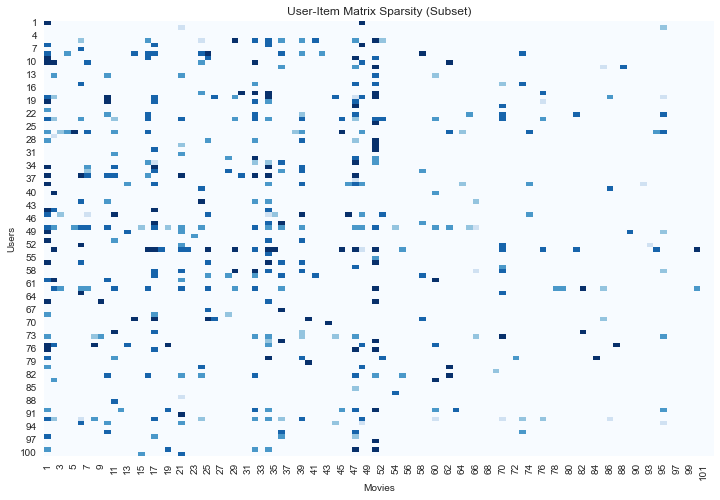

In [8]:
# Create the user-item matrix (replace the NaN values with 0s)
user_item_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
display(user_item_matrix.head())

# Randomly choose one user as test set
np.random.seed(42)  # for reproducibility
test_user = np.random.choice(user_item_matrix.index)

# Create a small subset of the user-item matrix for visualization
user_item_matrix_subset = user_item_matrix.iloc[:100, :100] 

# Plot heatmap to show matrix sparsity
plt.figure(figsize=(12, 8))
sns.heatmap(user_item_matrix_subset, cmap="Blues", cbar=False)
plt.title("User-Item Matrix Sparsity (Subset)")
plt.xlabel('Movies')
plt.ylabel('Users')
plt.show()

In [9]:
# Split the data for the test user (train-test split for the selected user)
test_user_ratings = user_item_matrix.loc[test_user]
train_user_ratings, test_user_ratings = train_test_split(test_user_ratings[test_user_ratings > 0], test_size=0.2, random_state=42)

# Create train and test matrices
train_matrix = user_item_matrix.copy()
train_matrix.loc[test_user] = train_user_ratings

test_matrix = pd.DataFrame(index=[test_user], columns=user_item_matrix.columns)
test_matrix.loc[test_user] = test_user_ratings

In [16]:
def compute_cosine_similarity(matrix):
    """
    Compute the cosine similarity matrix for a given matrix
    
    :param matrix: DataFrame, where rows are users and columns are users, with ratings as values.
    :return: Cosine similarity matrix as a 2D numpy array, where each entry (i, j) represents the cosine similarity between user i and user j.
    """
    dense_matrix = np.array(matrix.fillna(0))
    # Calculate cosine similarity on the dense matrix and return the similarity matrix
    return cosine_similarity(dense_matrix)

def compute_pearson_similarity(matrix):
    """
    Computes the Pearson correlation similarity matrix for a given matrix.
    
    :param matrix: DataFrame, where rows are users and columns are items, with ratings as values.
    :return: Pearson correlation similarity matrix as a 2D numpy array, where each entry (i, j) represents the Pearson correlation between user i and user j.
    """
    # Replace NaN values with 0 for calculation
    matrix = matrix.fillna(0)
    # Compute Pearson correlation matrix by transposing and applying correlation method
    correlation_matrix = matrix.T.corr(method='pearson')
    # Fill any remaining NaN values with 0 and return as a numpy array
    return correlation_matrix.fillna(0).values

def predict_rating(user_id, movie_id, similarity_matrix, train_matrix, k):
    """
    Predicts a user's rating for a specific movie based on k nearest neighbours.
    
    :param user_id: the ID of the user for whom the rating is being predicted.
    :param movie_id: the ID of the movie to predict the rating for.
    :param similarity_matrix: 2D number array representing user-user similarities.
    :param train_matrix: DataFrame, training data where rows are users and columns are items
    :param k: the nearest neighbours considered for prediction
    :return: 
    """
    # Get the index of the user in the similarity matrix
    user_index = train_matrix.index.get_loc(user_id)
    # Identify the top k most similar users, excluding the user themselves
    similar_users = np.argsort(similarity_matrix[user_index])[::-1][1:k+1]

    # Calculate the weighted average of ratings from the k nearest neighbors
    numerator = sum(
        similarity_matrix[user_index][neighbor] * train_matrix.iloc[neighbor][movie_id]
        for neighbor in similar_users if train_matrix.iloc[neighbor][movie_id] > 0
    )
    # Calculate the sum of absolute similarities of the k nearest neighbors
    denominator = sum(
        abs(similarity_matrix[user_index][neighbor])
        for neighbor in similar_users if train_matrix.iloc[neighbor][movie_id] > 0
    )

    # If no valid neighbors found, return the user's mean rating as fallback
    if denominator == 0:
        return train_matrix.iloc[user_index].mean()
    # Return the predicted rating as the weighted average
    return numerator / denominator

def evaluate_knn(test_user, similarity_matrix, train_matrix, test_matrix, k):
    """
    Evaluates the kNN model using Root Mean Squared Error (RMSE).
    
    :param test_user: the ID of the user to evaluate the model for.
    :param similarity_matrix: 2D numpy array representing user-user similarities.
    :param train_matrix: DataFrame, training data where rows are users and columns are items.
    :param test_matrix: DataFrame, test data where rows are users and columns are items.
    :param k: the number of nearest neighbors to consider for predictions.
    :return: RMSE value representing the prediction accuracy for the specified user.
    """
    # Initialize lists to store predicted ratings and actual ratings for RMSE calculation
    predictions = []
    actuals = []

    # Loop over each movie the user has rated in the test set
    for movie in test_matrix.columns:
        # Only consider movies that have been rated by the test user
        if test_matrix.loc[test_user, movie] > 0:
            # Predict rating for the movie using kNN
            pred = predict_rating(test_user, movie, similarity_matrix, train_matrix, k)
            # Append predicted and actual ratings to lists
            predictions.append(pred)
            actuals.append(test_matrix.loc[test_user, movie])

    # Compute RMSE between actual and predicted ratings and return
    rmse = sqrt(mean_squared_error(actuals, predictions))
    return rmse

In [11]:
# Compute similarity matrices
cosine_similarity_matrix = compute_cosine_similarity(train_matrix)
pearson_similarity_matrix = compute_pearson_similarity(train_matrix)

k = 5, Cosine RMSE = 1.5364808913766421, Pearson RMSE = 1.5359884544180002
k = 10, Cosine RMSE = 1.1485747909030977, Pearson RMSE = 1.1487817363553747
k = 20, Cosine RMSE = 0.8944026533665385, Pearson RMSE = 0.9504584179453992
k = 50, Cosine RMSE = 0.8812219469586614, Pearson RMSE = 0.9078668437707573
k = 100, Cosine RMSE = 0.8771333645525055, Pearson RMSE = 0.8787680516483982

Optimal k for Cosine = 100 with RMSE = 0.8771333645525055
Optimal k for Pearson = 100 with RMSE = 0.8787680516483982


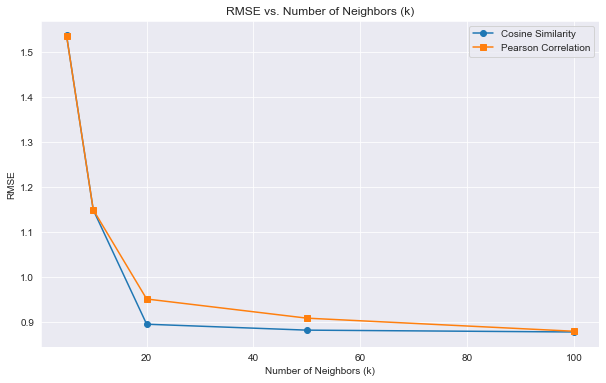

,MovieID,Predicted Rating,Actual Rating
0,21,3.669552,4.0
1,449,4.000000,5.0
2,1257,4.006865,5.0
3,1270,4.228521,5.0
4,1663,4.107669,5.0
5,2003,3.307900,4.0
6,2111,3.133921,4.0
7,2134,3.982592,5.0
8,2144,4.027593,5.0
9,2247,2.949964,3.0


In [17]:
# Test different k values and evaluate RMSE
k_values = [5, 10, 20, 50, 100]
cosine_results = []
pearson_results = []

for k in k_values:
    cosine_rmse = evaluate_knn(test_user, cosine_similarity_matrix, train_matrix, test_matrix, k)
    pearson_rmse = evaluate_knn(test_user, pearson_similarity_matrix, train_matrix, test_matrix, k)
    cosine_results.append((k, cosine_rmse))
    pearson_results.append((k, pearson_rmse))
    print(f"k = {k}, Cosine RMSE = {cosine_rmse}, Pearson RMSE = {pearson_rmse}")

# Find the optimal k value for each method
optimal_k_cosine = min(cosine_results, key=lambda x: x[1])
optimal_k_pearson = min(pearson_results, key=lambda x: x[1])
print(f"\nOptimal k for Cosine = {optimal_k_cosine[0]} with RMSE = {optimal_k_cosine[1]}")
print(f"Optimal k for Pearson = {optimal_k_pearson[0]} with RMSE = {optimal_k_pearson[1]}")

# Visualization of RMSE vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, [r[1] for r in cosine_results], marker='o', label='Cosine Similarity')
plt.plot(k_values, [r[1] for r in pearson_results], marker='s', label='Pearson Correlation')
plt.title('RMSE vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

def get_user_predictions(test_user, similarity_matrix, train_matrix, test_matrix, k):
    """
    Generate predictions for a specific user for all rated movies in the test set.
    :param test_user: the ID of the user for whom predictions are being generated.
    :param similarity_matrix: 2D numpy array representing user-user similarities.
    :param train_matrix: DataFrame, training data where rows are users and columns are items, with ratings as values.
    :param test_matrix: DataFrame, test data where rows are users and columns are items, with ratings as values.
    :param k: the number of nearest neighbors to consider for predictions.
    :return: 
        - predictions: a list of tuples (movie_id, predicted_rating) for each movie the user has rated in the test set.
        - actuals: a list of tuples (movie_id, actual_rating) for each movie the user has rated in the test set.
    """
    # Initialize lists to store predictions and actual ratings for evaluation
    predictions = []
    actuals = []

    # Get a list of all movies in the test matrix
    movies = test_matrix.columns

    # Iterate over each movie to generate predictions for the test user
    for movie in movies:
        # Only consider movies that the test user has rated in the test set        
        if test_matrix.loc[test_user, movie] > 0:
            # Predict the rating for the movie using kNN            
            pred = predict_rating(test_user, movie, similarity_matrix, train_matrix, k)
            # Append the predicted rating as a tuple (movie_id, predicted_rating)           
            predictions.append((movie, pred))
            # Append the actual rating as a tuple (movie_id, actual_rating)
            actuals.append((movie, test_matrix.loc[test_user, movie]))
            
    # Return the list of predictions and actual ratings for evaluation
    return predictions, actuals

# Get predictions for the test user using the optimal k value
optimal_k = optimal_k_cosine[0]  # Use the optimal k value from cosine similarity
predictions, actuals = get_user_predictions(test_user, cosine_similarity_matrix, train_matrix, test_matrix, optimal_k)

# Convert to DataFrame for visualization
predictions_df = pd.DataFrame(predictions, columns=['MovieID', 'Predicted Rating'])
actuals_df = pd.DataFrame(actuals, columns=['MovieID', 'Actual Rating'])

# Merge the DataFrames to compare actual and predicted ratings
results_df = pd.merge(predictions_df, actuals_df, on='MovieID')
display(results_df.head(20))  # Display the first 20 predictions and actual ratings


# Task 2: Matrix Factorization-based Recommendation

## Initial Model

In [ ]:
# Create a surprise reader object
reader = Reader(rating_scale=(1, 5))

# Load the data into the Surprise format
data = Dataset.load_from_df(ratings[['UserID', 'MovieID', 'Rating']], reader)

In [18]:
# Randomly choose 5 movies at test set
np.random.seed(42)
all_movies = ratings['MovieID'].unique()
test_movies = np.random.choice(all_movies, size=5, replace=False)

In [19]:
# Split the data
train_data = ratings[~ratings['MovieID'].isin(test_movies)]
test_data = ratings[ratings['MovieID'].isin(test_movies)]

In [156]:
# Train and evaluate the model
def train_and_evaluate(model, train_data, test_data):
    """
    Trains the given model on the training dataset and evaluates it on the test dataset using RMSE.
    
    :param model: the recommendation model to be trained
    :param train_data: DataFrame containing training data with columns 'UserID', 'MovieID', and 'Rating'.
    :param test_data: DataFrame containing test data with columns 'UserID', 'MovieID', and 'Rating'.
    :return: rmse score
    """
    # Load training data into a format suitable for the model and train it
    trainset = Dataset.load_from_df(train_data[['UserID', 'MovieID', 'Rating']], reader).build_full_trainset()
    model.fit(trainset)

    # Generate predictions for each user-movie pair in the test set
    predictions = [model.predict(row['UserID'], row['MovieID']).est for _, row in test_data.iterrows()]

    # Calculate RMSE for the model's performance on the test set
    rmse = sqrt(mean_squared_error(test_data['Rating'], predictions))

    # Return the RMSE value to indicate model accuracy
    return rmse

In [21]:
def get_top_n_recommendations(model, user_id, n=5):
    """
    Retrieves the top N movie recommendations for a given user.
    
    :param model: trained recommendation model
    :param user_id: ID of the user for whom recommendations are generated.
    :param n: number of top recommendations to retrieve (default is 5).
    :return: top_n: List of tuples (movie_id, predicted_rating) for the top N recommended movies.
    """
    # Get the list of all movies rated by the user to avoid re-recommending watched movies
    user_ratings = ratings[ratings['UserID'] == user_id]['MovieID']

    # Identify movies the user has not yet rated
    movies_to_predict = list(set(all_movies) - set(user_ratings))

    # Predict ratings for each movie the user hasn't rated
    predictions = [model.predict(user_id, movie_id).est for movie_id in movies_to_predict]

    # Sort movies by predicted ratings in descending order and select the top N
    top_n = sorted(zip(movies_to_predict, predictions), key=lambda x: x[1], reverse=True)[:n]

    # Return the list of top N recommended movies and their predicted ratings
    return top_n

In [22]:
# Initial model evaluation
initial_model = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
start_time = time.time()
initial_rmse = train_and_evaluate(initial_model, train_data, test_data)
initial_time = time.time() - start_time
print(f"Initial RMSE: {initial_rmse}")
print(f"Initial model execution time: {initial_time:.2f} seconds")

Initial RMSE: 1.0115822840572373
Initial model execution time: 12.23 seconds


## Improved approach

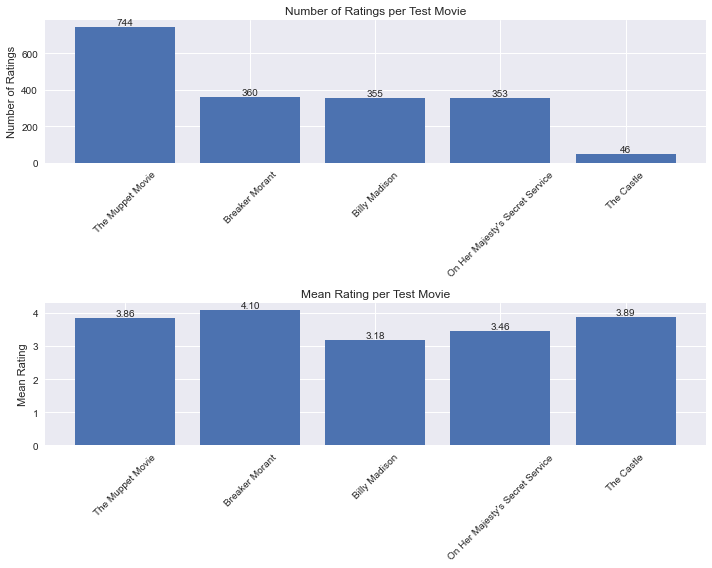

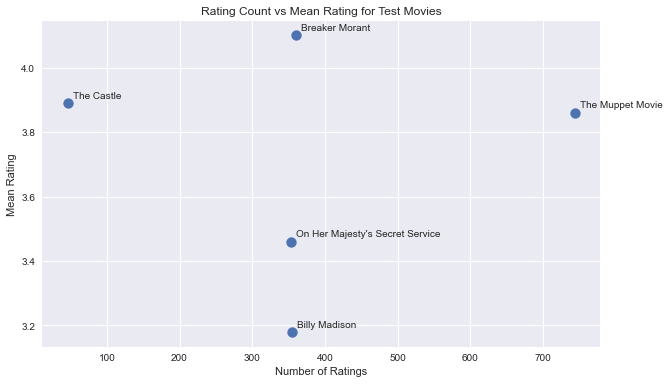

In [155]:
# Test Movies Rating Distribution
def plot_rating_distribution():
    """
    Plots two bar charts for a set of test movies:
    1. The number of ratings each movie received.
    2. The mean rating for each movie.
    
    This provides an overview of the popularity (number of ratings) and average rating of each test movie to analyze rating trends.
    """
    # Define test movies and their respective ratings data    
    movies = ['The Muppet Movie', 'Breaker Morant', 'Billy Madison',
              "On Her Majesty's Secret Service", 'The Castle']
    ratings_count = [744, 360, 355, 353, 46]
    mean_ratings = [3.86, 4.10, 3.18, 3.46, 3.89]

    # Create two subplots for number of ratings and mean ratings
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot the number of ratings for each movie in the top subplot
    bars = ax1.bar(movies, ratings_count)
    ax1.set_title('Number of Ratings per Test Movie')
    ax1.set_ylabel('Number of Ratings')
    ax1.tick_params(axis='x', rotation=45)

    # Annotate each bar with the rating count
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom')

    # Plot the mean rating for each movie in the bottom subplot
    bars = ax2.bar(movies, mean_ratings)
    ax2.set_title('Mean Rating per Test Movie')
    ax2.set_ylabel('Mean Rating')
    ax2.tick_params(axis='x', rotation=45)

    # Annotate each bar with the mean rating value
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}', ha='center', va='bottom')

    # Adjust layout to prevent overlap and display the plot
    plt.tight_layout()
    plt.show()

# Function to plot the relationship between number of ratings and mean rating for test movies
def plot_ratings_vs_error():
    """
    Plots a scatter plot of rating count vs mean rating for selected test movies, with annotations to label each movie on the plot.

    This visualization helps in understanding if there's a correlation between the popularity (number of ratings) and the average rating of each movie.
    """
    # Define data for ratings count and mean ratings for test movies
    ratings_count = [744, 360, 355, 353, 46]
    mean_ratings = [3.86, 4.10, 3.18, 3.46, 3.89]
    movies = ['The Muppet Movie', 'Breaker Morant', 'Billy Madison',
              "On Her Majesty's Secret Service", 'The Castle']

    # Create scatter plot of ratings count vs mean rating
    plt.figure(figsize=(10, 6))
    plt.scatter(ratings_count, mean_ratings, s=100)

    # Add movie labels to each point on the scatter plot
    for i, movie in enumerate(movies):
        plt.annotate(movie, (ratings_count[i], mean_ratings[i]),
                     xytext=(5, 5), textcoords='offset points')

    # Set plot labels and title for clarity
    plt.xlabel('Number of Ratings')
    plt.ylabel('Mean Rating')
    plt.title('Rating Count vs Mean Rating for Test Movies')
    plt.grid(True)
    plt.show()

# Generate and display all plots for analysis
plot_rating_distribution()
plot_ratings_vs_error()

In [12]:
reader = Reader(rating_scale=(1, 5))

# Get our test movies
test_movies = [2618, 3633, 3811, 216, 3396]
train_data = ratings[~ratings['MovieID'].isin(test_movies)]
test_data = ratings[ratings['MovieID'].isin(test_movies)]

# Convert to Surprise format
trainset = Dataset.load_from_df(train_data[['UserID', 'MovieID', 'Rating']], reader).build_full_trainset()
testset = [(uid, mid, r) for _, uid, mid, r in test_data[['UserID', 'MovieID', 'Rating']].itertuples()]

Starting comprehensive parameter tuning...
n_factors: 20, reg_all: 0.02, n_epochs: 15, lr_all: 0.002, RMSE: 1.0088
n_factors: 20, reg_all: 0.02, n_epochs: 15, lr_all: 0.005, RMSE: 1.0117
n_factors: 20, reg_all: 0.02, n_epochs: 15, lr_all: 0.007, RMSE: 1.0134
n_factors: 20, reg_all: 0.02, n_epochs: 15, lr_all: 0.01, RMSE: 1.0140
n_factors: 20, reg_all: 0.02, n_epochs: 20, lr_all: 0.002, RMSE: 1.0090
n_factors: 20, reg_all: 0.02, n_epochs: 20, lr_all: 0.005, RMSE: 1.0129
n_factors: 20, reg_all: 0.02, n_epochs: 20, lr_all: 0.007, RMSE: 1.0136
n_factors: 20, reg_all: 0.02, n_epochs: 20, lr_all: 0.01, RMSE: 1.0134
n_factors: 20, reg_all: 0.02, n_epochs: 25, lr_all: 0.002, RMSE: 1.0093
n_factors: 20, reg_all: 0.02, n_epochs: 25, lr_all: 0.005, RMSE: 1.0133
n_factors: 20, reg_all: 0.02, n_epochs: 25, lr_all: 0.007, RMSE: 1.0132
n_factors: 20, reg_all: 0.02, n_epochs: 25, lr_all: 0.01, RMSE: 1.0129
n_factors: 20, reg_all: 0.02, n_epochs: 30, lr_all: 0.002, RMSE: 1.0099
n_factors: 20, reg_all: 

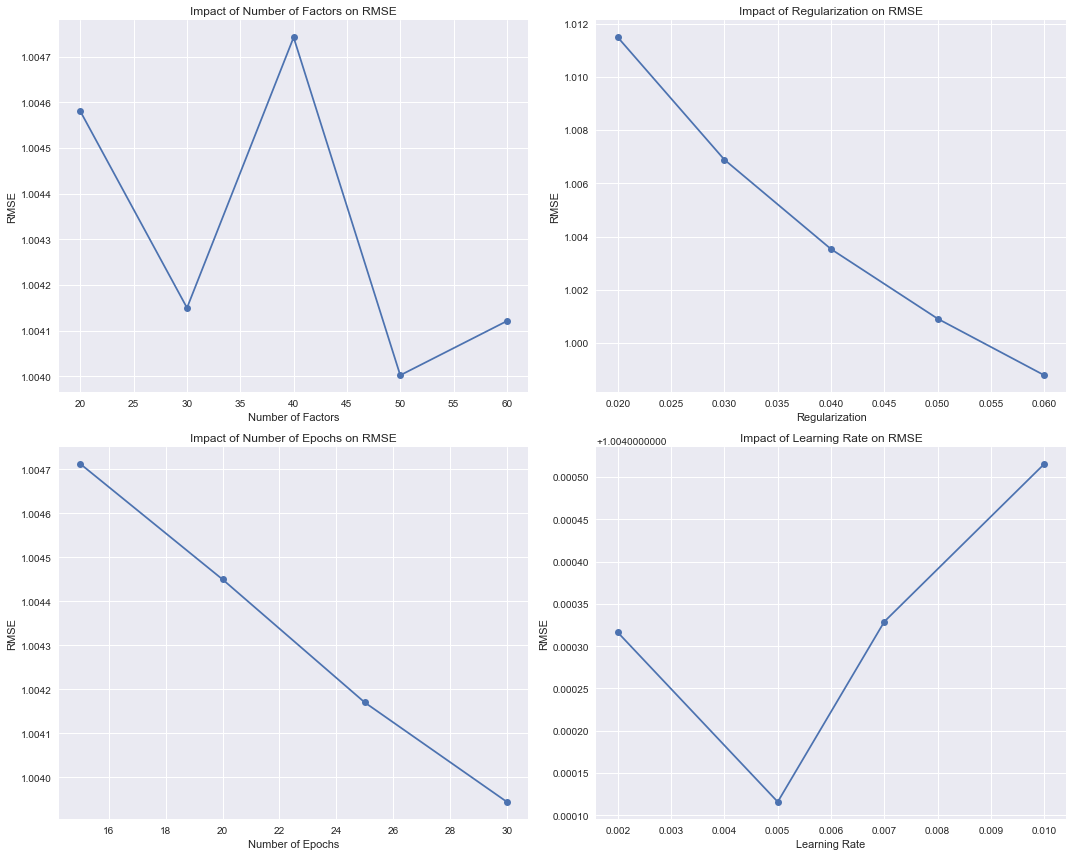

In [52]:
# Define parameter ranges for hyperparameter tuning
n_factors_range = [20, 30, 40, 50, 60]
reg_all_range = [0.02, 0.03, 0.04, 0.05, 0.06]
n_epochs_range = [15, 20, 25, 30]
lr_all_range = [0.002, 0.005, 0.007, 0.01]

# Initialize list to store tuning results
results = []

print("Starting comprehensive parameter tuning...")

# Perform grid search by testing all combinations of parameters
for n_factors in n_factors_range:
    for reg_all in reg_all_range:
        for n_epochs in n_epochs_range:
            for lr_all in lr_all_range:
                # Initialize SVD model with current parameter combination
                model = SVD(
                    n_factors=n_factors,
                    reg_all=reg_all,
                    n_epochs=n_epochs,
                    lr_all=lr_all,
                    random_state=42
                )

                # Fit model to training data and test on the test set
                model.fit(trainset)
                predictions = model.test(testset)

                # Calculate RMSE for the model predictions
                rmse = np.sqrt(np.mean([float((pred.r_ui - pred.est) ** 2)
                                        for pred in predictions]))
                
                # Store parameter combination and corresponding RMSE
                results.append({
                    'n_factors': n_factors,
                    'reg_all': reg_all,
                    'n_epochs': n_epochs,
                    'lr_all': lr_all,
                    'rmse': rmse
                })

                # Print progress with current parameters and RMSE
                print(f"n_factors: {n_factors}, reg_all: {reg_all}, "
                      f"n_epochs: {n_epochs}, lr_all: {lr_all}, RMSE: {rmse:.4f}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Find best configuration
best_result = results_df.loc[results_df['rmse'].idxmin()]
print("\nOptimal Parameters:")
print(f"n_factors: {best_result['n_factors']}")
print(f"reg_all: {best_result['reg_all']}")
print(f"n_epochs: {best_result['n_epochs']}")
print(f"lr_all: {best_result['lr_all']}")
print(f"Best RMSE: {best_result['rmse']:.4f}")

# Plotting the impact of each parameter on RMSE to visualize tuning results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Set up plotting parameters for visualization
params = {
    'n_factors': (n_factors_range, ax1, 'Number of Factors'),
    'reg_all': (reg_all_range, ax2, 'Regularization'),
    'n_epochs': (n_epochs_range, ax3, 'Number of Epochs'),
    'lr_all': (lr_all_range, ax4, 'Learning Rate')
}

# Loop through each parameter to plot RMSE impact, averaging other parameters
for param, (param_range, ax, title) in params.items():
    mean_rmse = [results_df[results_df[param] == val]['rmse'].mean()
                 for val in param_range]
    ax.plot(param_range, mean_rmse, marker='o')
    ax.set_xlabel(title)
    ax.set_ylabel('RMSE')
    ax.grid(True)
    ax.set_title(f'Impact of {title} on RMSE')

# Display plot with all parameter impact graphs
plt.tight_layout()
plt.show()

## Optimal Model

In [87]:
improved_svd_model = SVD(n_factors=30, reg_all=0.06, n_epochs=30, lr_all=0.005, random_state=42)

# Fit the model using the full training dataset
trainset = Dataset.load_from_df(train_data[['UserID', 'MovieID', 'Rating']], reader).build_full_trainset()
improved_svd_model.fit(trainset)

# Task 3: Ranking-based Evaluation and Comparison

### Data Splitting

In [303]:
from sklearn.metrics import ndcg_score, average_precision_score

def create_train_test_split(ratings_df, test_size=0.2):
    """
    Split the ratings data into training and test sets for model evaluation.

    :param ratings_df: DataFrame containing user ratings, with columns 'UserID', 'MovieID', 'Rating', and others.
    :param test_size: Proportion of ratings to include in the test set for each user.
    :return: Two DataFrames, one for training and one for testing.
    """
    # Set a random seed for reproducibility of the split
    np.random.seed(42)

    # Initialize empty DataFrames to accumulate training and test data
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()

    # Loop over each unique user in the dataset
    for user_id in ratings_df['UserID'].unique():
        # Filter ratings for the current user
        user_ratings = ratings_df[ratings_df['UserID'] == user_id]

        # Calculate the number of ratings to include in the test set for this user
        test_size_user = int(len(user_ratings) * test_size)
        test_indices = np.random.choice(user_ratings.index, size=test_size_user, replace=False)

        # Add selected ratings to the test set and the remaining to the training set
        test_df = pd.concat([test_df, user_ratings.loc[test_indices]])
        train_df = pd.concat([train_df, user_ratings.drop(test_indices)])
        
    # Return the split data
    return train_df, test_df

### KNN Implementation

In [304]:
def get_knn_predictions(user_id, movie_ids, train_df, k=100):
    """
    Generate movie rating predictions for a specific user using K-Nearest Neighbors (kNN).

    :param user_id: The ID of the user for whom predictions are generated.
    :param movie_ids: List of movie IDs for which predictions are required.
    :param train_df: DataFrame containing training data of user ratings.
    :param k: Number of nearest neighbors to consider.
    :return: List of tuples with movie ID and predicted rating.
    """
    # Create a user-item matrix with movies as columns and users as rows
    user_item_matrix = train_df.pivot(
        index='UserID',
        columns='MovieID',
        values='Rating'
    ).fillna(0)

    # Retrieve ratings for the target user and calculate mean and standard deviation
    target_user_ratings = user_item_matrix.loc[user_id]
    target_mean = target_user_ratings[target_user_ratings > 0].mean()
    target_std = target_user_ratings[target_user_ratings > 0].std()

    # Calculate similarities between target user and all other users
    similarities = []
    for other_user in user_item_matrix.index:
        if other_user != user_id:
            # Get ratings for other user and filter common rated movies
            other_ratings = user_item_matrix.loc[other_user]
            mask = (target_user_ratings != 0) & (other_ratings != 0)
            if mask.sum() >= 5: # Only proceed if 5+ common movies are rated
                target_common = target_user_ratings[mask]
                other_common = other_ratings[mask]

                # Normalize ratings of target and other user
                target_norm = (target_common - target_common.mean()) / (target_common.std() + 1e-10)
                other_norm = (other_common - other_common.mean()) / (other_common.std() + 1e-10)

                # Compute cosine similarity between normalized ratings
                sim = np.dot(target_norm, other_norm) / (
                        np.linalg.norm(target_norm) * np.linalg.norm(other_norm) + 1e-10
                )
                if not np.isnan(sim):
                    similarities.append((other_user, sim))

    # Sort users by similarity and select the top k neighbors
    similarities.sort(key=lambda x: x[1], reverse=True)
    neighbors = similarities[:k]

    # Predict ratings for each movie in the input list
    predictions = []
    for movie_id in movie_ids:
        weighted_sum = 0
        sim_sum = 0
        neighbor_ratings = []

        for neighbor, sim in neighbors:
            # Check if the neighbor has rated the current movie
            rating = train_df[(train_df['UserID'] == neighbor) &
                              (train_df['MovieID'] == movie_id)]['Rating']
            if not rating.empty:
                # Retrieve and normalize neighbor’s rating
                neighbor_ratings_all = train_df[train_df['UserID'] == neighbor]['Rating']
                neighbor_mean = neighbor_ratings_all.mean()
                neighbor_std = neighbor_ratings_all.std()

                # Normalize the rating and compute weighted sum
                normalized_rating = (rating.iloc[0] - neighbor_mean) / (neighbor_std + 1e-10)
                weighted_sum += normalized_rating * sim
                sim_sum += abs(sim)
                neighbor_ratings.append(rating.iloc[0])

        if sim_sum > 0 and neighbor_ratings:
            # Convert normalized prediction back to original scale
            base_pred = weighted_sum / sim_sum
            pred = target_mean + (base_pred * target_std)

            # Blend with movie's average rating if available
            movie_ratings = train_df[train_df['MovieID'] == movie_id]['Rating']
            if not movie_ratings.empty:
                movie_mean = movie_ratings.mean()
                # Use a weighted approach based on number of neighbors who rated the movie
                weight = min(len(neighbor_ratings) / 20, 1.0)  # More neighbors = more weight to personalized
                pred = weight * pred + (1 - weight) * movie_mean

            # Clip predicted rating within a valid range (1 to 5)
            pred = max(1.0, min(5.0, pred))
            predictions.append((movie_id, pred))

    return predictions

### SVD Implementation - Training and Evaluating Models

In [305]:
def train_and_evaluate_models(train_df, test_df):
    """
    Train and evaluate both KNN and SVD recommendation models on the test set.
    
    :param train_df: DataFrame containing training data with user ratings.
    :param test_df: DataFrame containing test data for evaluation.
    :return: DataFrame of evaluation results and trained SVD model.
    """
    print("Training models...")

    # Initialize the Surprise library reader with rating scale (1 to 5)
    reader = Reader(rating_scale=(1, 5))

    # Load training data into Surprise's Dataset object for SVD
    train_data = Dataset.load_from_df(train_df[['UserID', 'MovieID', 'Rating']], reader)
    trainset = train_data.build_full_trainset()

    # Train the SVD model with predefined optimal parameters from task 2
    svd_model = SVD(n_factors=30, n_epochs=30, lr_all=0.005, reg_all=0.06)
    svd_model.fit(trainset)

    # Initialize the evaluation process
    print("\nEvaluating models on test set...")
    test_users = test_df['UserID'].unique() # List of unique users in the test set
    results = [] # Container for evaluation results

    for user_id in test_users[:10]:  # Sample 10 users for evaluation
        # Extract test ratings for the current user
        test_ratings = test_df[test_df['UserID'] == user_id]

        if len(test_ratings) >= 5:  # Only evaluate if enough test ratings (5+)
            print(f"\nEvaluating User {user_id}")
            print(f"Test ratings: {len(test_ratings)}")

            # Get actual ratings for evaluation
            actual_ratings = test_ratings.set_index('MovieID')['Rating'].to_dict()
            test_movies = test_ratings['MovieID'].unique()

            # Generate SVD predictions
            svd_predictions = []
            for movie_id in test_movies:
                pred = svd_model.predict(user_id, movie_id).est
                svd_predictions.append((movie_id, pred))

            # Generate KNN predictions
            knn_predictions = get_knn_predictions(user_id, test_movies, train_df)

            # Calculate AP and NDCG for each model
            knn_ap = calculate_ap(knn_predictions, actual_ratings)
            knn_ndcg = calculate_ndcg(knn_predictions, actual_ratings)
            svd_ap = calculate_ap(svd_predictions, actual_ratings)
            svd_ndcg = calculate_ndcg(svd_predictions, actual_ratings)

            # Print metrics for each model
            print(f"KNN - AP: {knn_ap:.4f}, NDCG: {knn_ndcg:.4f}")
            print(f"SVD - AP: {svd_ap:.4f}, NDCG: {svd_ndcg:.4f}")

            # Store results for analysis
            results.append({
                'KNN_AP': knn_ap,
                'KNN_NDCG': knn_ndcg,
                'SVD_AP': svd_ap,
                'SVD_NDCG': svd_ndcg
            })

    return pd.DataFrame(results), svd_model # Return evaluation results and trained SVD model

### Generate Recommendations

In [306]:
def generate_recommendations(ratings_df, svd_model, min_ratings=100):
    """
    Generate movie recommendations for active users using both SVD and KNN models.
    
    :param ratings_df: DataFrame containing user ratings.
    :param svd_model: Trained SVD model used for generating recommendations.
    :param min_ratings: Minimum number of ratings required for a user to be considered active.
    :return: Dictionary containing top recommendations for each active user by model (SVD and KNN).
    """
    print("\nGenerating recommendations for active users...")

    # Identify active users with ratings exceeding the minimum threshold (100)
    user_counts = ratings_df['UserID'].value_counts()
    active_users = user_counts[user_counts >= min_ratings].index

    recommendations = {'KNN': {}, 'SVD': {}} # Container for SVD and KNN recommendations
    for user_id in active_users[:5]:  # Sample 5 users for demonstration
        print(f"\nGenerating recommendations for User {user_id}")

        # Identify movies the user has already rated
        rated_movies = set(ratings_df[ratings_df['UserID'] == user_id]['MovieID'])
        all_movies = set(ratings_df['MovieID'].unique())
        unrated_movies = list(all_movies - rated_movies)

        # Generate SVD predictions
        svd_predictions = []
        for movie_id in unrated_movies:
            pred = svd_model.predict(user_id, movie_id).est # Predict rating with SVD model
            svd_predictions.append((movie_id, pred))

        # Generate KNN predictions
        knn_predictions = get_knn_predictions(user_id, unrated_movies, ratings_df)

        # Sort predictions and select top recommendations for each model
        svd_top = sorted(svd_predictions, key=lambda x: x[1], reverse=True)[:10]
        knn_top = sorted(knn_predictions, key=lambda x: x[1], reverse=True)[:10]

        # Store recommendations for each model in the dictionary

        recommendations['SVD'][user_id] = svd_top
        recommendations['KNN'][user_id] = knn_top

        # Display top 5 recommendations from SVD for the current user
        print("\nTop 5 SVD recommendations:")
        for movie_id, score in svd_top[:5]:
            print(f"Movie {movie_id}: Predicted rating = {score:.2f}")

        # Display top 5 recommendations from KNN for the current user
        print("\nTop 5 KNN recommendations:")
        for movie_id, score in knn_top[:5]:
            print(f"Movie {movie_id}: Predicted rating = {score:.2f}")

    # Return dictionary containing recommendations from both models
    return recommendations

### Evaluation Metrics

In [307]:
def calculate_ap(predictions, true_ratings, threshold=3.5):
    """
    Calculate Average Precision (AP) for a set of predictions compared to true ratings.
    
    :param predictions: List of tuples (movie_id, predicted_score) from model predictions.
    :param true_ratings: Dictionary of actual ratings with movie_id as key and rating as value.
    :param threshold: Rating threshold for a 'relevant' rating (default is 3.5).
    :return: Average Precision score.
    """
    # Handle empty input cases to avoid calculation errors
    if not predictions or not true_ratings:
        return 0.0

    y_true = [] # Binary relevance scores based on the threshold
    y_score = [] # Model-predicted scores

    for movie_id, pred_score in predictions:
        true_rating = true_ratings.get(movie_id, 0)
        # Mark as relevant (1) if true rating meets/exceeds threshold, else non-relevant (0)
        y_true.append(1 if true_rating >= threshold else 0)
        y_score.append(pred_score)

    # Return 0.0 if no relevant items are found in true ratings
    if sum(y_true) == 0:
        return 0.0

    # Compute Average Precision based on relevance and predicted scores
    return average_precision_score(y_true, y_score)

In [308]:
def calculate_ndcg(predictions, true_ratings, k=20):
    """
    Calculate Normalized Discounted Cumulative Gain (NDCG) for predictions.
    
    :param predictions: List of tuples (movie_id, predicted_score) from model predictions.
    :param true_ratings: Dictionary of actual ratings with movie_id as key and rating as value.
    :param k: Number of top-ranked items to consider (default is 20).
    :return: NDCG score.
    """
    # Handle cases where input is empty to prevent calculation errors
    if not predictions or not true_ratings:
        return 0.0

    y_true = np.zeros((1, len(predictions))) # Array for true relevance scores
    y_score = np.zeros((1, len(predictions))) # Array for model-predicted scores

    for i, (movie_id, pred_score) in enumerate(predictions):
        y_true[0, i] = true_ratings.get(movie_id, 0) # Populate with actual rating
        y_score[0, i] = pred_score # Populate with predicted score

    # Return 0.0 if no relevant items are found in true ratings
    if np.sum(y_true) == 0:
        return 0.0

    # Compute NDCG using true and predicted scores
    return ndcg_score(y_true, y_score)

### Visualization

In [309]:
def visualize_results(results_df):
    """
    Create visualizations for AP and NDCG metrics
    """
    plt.style.use('seaborn-darkgrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # AP Comparison
    ax1.bar(['KNN', 'SVD'],
            [results_df['KNN_AP'].mean(), results_df['SVD_AP'].mean()],
            yerr=[results_df['KNN_AP'].std(), results_df['SVD_AP'].std()],
            capsize=5)
    ax1.set_title('Average Precision Comparison')
    ax1.set_ylabel('Average Precision')

    # NDCG Comparison
    ax2.bar(['KNN', 'SVD'],
            [results_df['KNN_NDCG'].mean(), results_df['SVD_NDCG'].mean()],
            yerr=[results_df['KNN_NDCG'].std(), results_df['SVD_NDCG'].std()],
            capsize=5)
    ax2.set_title('NDCG Comparison')
    ax2.set_ylabel('NDCG Score')

    plt.tight_layout()
    plt.show()


In [310]:
def main(ratings_df):
    """
    Complete recommendation system pipeline
    """
    # Split data for model evaluation
    print("Creating train-test split...")
    train_df, test_df = create_train_test_split(ratings_df)
    print(f"Train set: {len(train_df)} ratings")
    print(f"Test set: {len(test_df)} ratings")

    # Train and evaluate models
    evaluation_results, svd_model = train_and_evaluate_models(train_df, test_df)

    print("\nModel Evaluation Results:")
    metrics = ['KNN_AP', 'KNN_NDCG', 'SVD_AP', 'SVD_NDCG']
    mean_metrics = evaluation_results[metrics].mean()
    print("\nAverage Performance Metrics:")
    for metric in metrics:
        print(f"{metric}: {mean_metrics[metric]:.4f}")

    # Visualize results
    visualize_results(evaluation_results)

    # Generate recommendations for active users
    recommendations = generate_recommendations(ratings_df, svd_model)

    return evaluation_results, recommendations


Creating train-test split...
Train set: 802553 ratings
Test set: 197656 ratings
Training models...

Evaluating models on test set...

Evaluating User 1
Test ratings: 10
KNN - AP: 0.9283, NDCG: 0.9948
SVD - AP: 0.8412, NDCG: 0.9494

Evaluating User 2
Test ratings: 25
KNN - AP: 0.8404, NDCG: 0.9678
SVD - AP: 0.8534, NDCG: 0.9761

Evaluating User 3
Test ratings: 10
KNN - AP: 0.9129, NDCG: 0.9684
SVD - AP: 0.9214, NDCG: 0.9955

Evaluating User 5
Test ratings: 39
KNN - AP: 0.7551, NDCG: 0.9520
SVD - AP: 0.8594, NDCG: 0.9692

Evaluating User 6
Test ratings: 14
KNN - AP: 0.9105, NDCG: 0.9543
SVD - AP: 0.9563, NDCG: 0.9729

Evaluating User 7
Test ratings: 6
KNN - AP: 1.0000, NDCG: 0.9611
SVD - AP: 1.0000, NDCG: 0.9845

Evaluating User 8
Test ratings: 27
KNN - AP: 0.9004, NDCG: 0.9846
SVD - AP: 0.8465, NDCG: 0.9795

Evaluating User 9
Test ratings: 21
KNN - AP: 0.8388, NDCG: 0.9716
SVD - AP: 0.8031, NDCG: 0.9740

Evaluating User 10
Test ratings: 80
KNN - AP: 0.6511, NDCG: 0.9472
SVD - AP: 0.7980

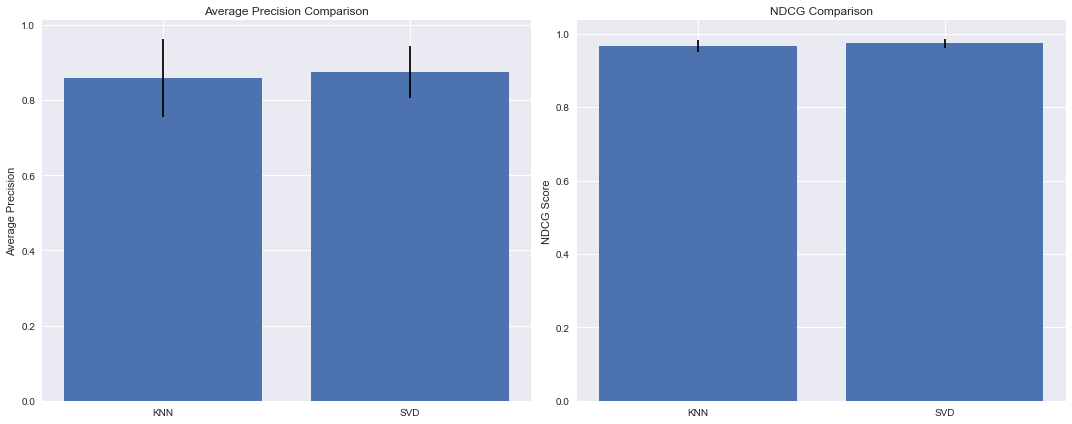


Generating recommendations for active users...

Generating recommendations for User 4169

Top 5 SVD recommendations:
Movie 1148: Predicted rating = 4.75
Movie 3022: Predicted rating = 4.70
Movie 745: Predicted rating = 4.70
Movie 3338: Predicted rating = 4.69
Movie 720: Predicted rating = 4.62

Top 5 KNN recommendations:
Movie 1830: Predicted rating = 4.98
Movie 1148: Predicted rating = 4.47
Movie 745: Predicted rating = 4.46
Movie 720: Predicted rating = 4.42
Movie 3022: Predicted rating = 4.39

Generating recommendations for User 1680

Top 5 SVD recommendations:
Movie 668: Predicted rating = 4.76
Movie 2905: Predicted rating = 4.73
Movie 2503: Predicted rating = 4.72
Movie 3634: Predicted rating = 4.71
Movie 3338: Predicted rating = 4.67

Top 5 KNN recommendations:
Movie 3897: Predicted rating = 4.53
Movie 1178: Predicted rating = 4.45
Movie 3911: Predicted rating = 4.39
Movie 2324: Predicted rating = 4.37
Movie 1204: Predicted rating = 4.35

Generating recommendations for User 4277

In [311]:
# Usage:
if __name__ == "__main__":
    # Load data
    ratings_df = pd.read_csv('C:/Users/Nguyen Ngoc Hai/PycharmProjects/COSC2670 - Practice/ASM 3/ratings.dat', encoding='latin-1', sep='::', engine='python', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

    # Run evaluation
    results, recommendations = main(ratings_df)

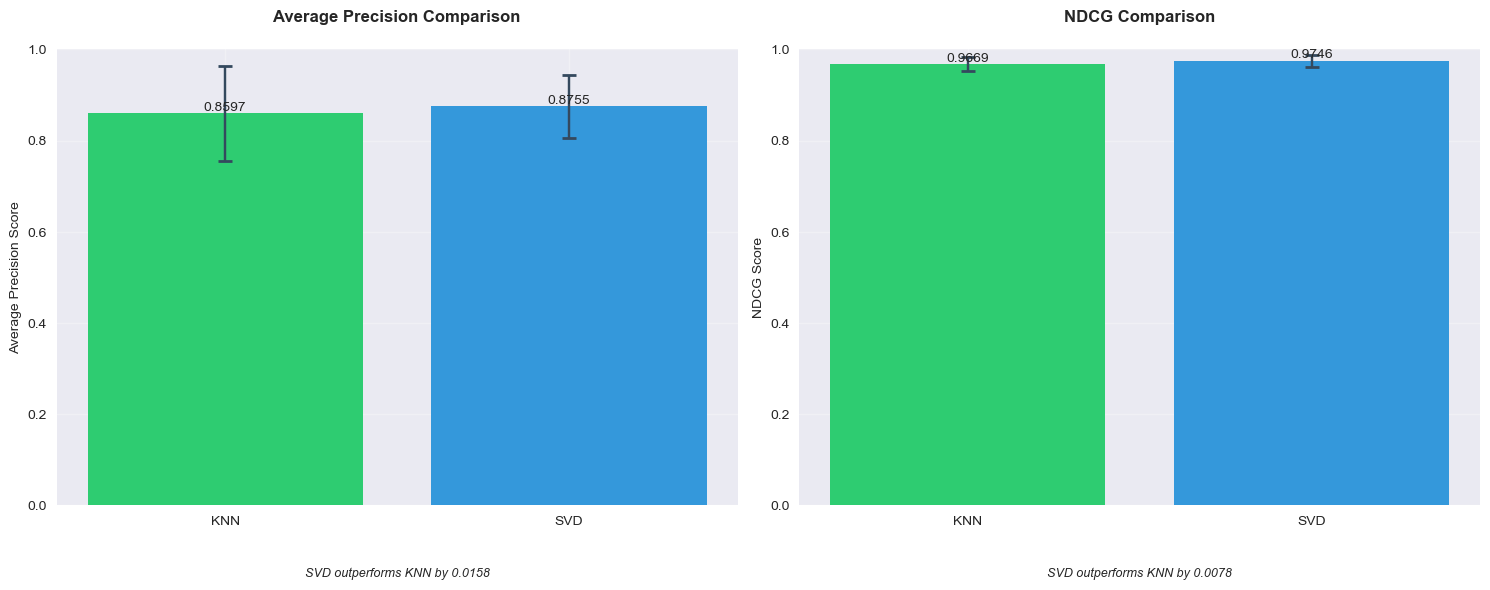

In [312]:
def visualize_model_comparison(results_df):
    """
    Standalone visualization function for model comparison
    Input: results_df from main() output
    """
    plt.style.use('seaborn-darkgrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), dpi=100)

    # Colors
    bar_colors = ['#2ecc71', '#3498db']
    error_color = '#34495e'

    # Calculate metrics
    ap_means = [results_df['KNN_AP'].mean(), results_df['SVD_AP'].mean()]
    ap_stds = [results_df['KNN_AP'].std(), results_df['SVD_AP'].std()]
    ndcg_means = [results_df['KNN_NDCG'].mean(), results_df['SVD_NDCG'].mean()]
    ndcg_stds = [results_df['KNN_NDCG'].std(), results_df['SVD_NDCG'].std()]

    # Plot AP
    bars1 = ax1.bar(['KNN', 'SVD'], ap_means, yerr=ap_stds,
                    capsize=5, color=bar_colors,
                    error_kw={'ecolor': error_color, 'capthick': 2})

    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom')

    ax1.set_title('Average Precision Comparison', pad=20, fontsize=12, fontweight='bold')
    ax1.set_ylabel('Average Precision Score', fontsize=10)
    ax1.set_ylim(0, 1.0)
    ax1.grid(True, alpha=0.3)

    # Plot NDCG
    bars2 = ax2.bar(['KNN', 'SVD'], ndcg_means, yerr=ndcg_stds,
                    capsize=5, color=bar_colors,
                    error_kw={'ecolor': error_color, 'capthick': 2})

    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom')

    ax2.set_title('NDCG Comparison', pad=20, fontsize=12, fontweight='bold')
    ax2.set_ylabel('NDCG Score', fontsize=10)
    ax2.set_ylim(0, 1.0)
    ax2.grid(True, alpha=0.3)

    # Add performance difference
    ap_diff = ap_means[1] - ap_means[0]
    ndcg_diff = ndcg_means[1] - ndcg_means[0]

    ax1.text(0.5, -0.15, f'SVD outperforms KNN by {abs(ap_diff):.4f}',
             ha='center', va='center', transform=ax1.transAxes,
             fontsize=9, style='italic')
    ax2.text(0.5, -0.15, f'SVD outperforms KNN by {abs(ndcg_diff):.4f}',
             ha='center', va='center', transform=ax2.transAxes,
             fontsize=9, style='italic')

    plt.tight_layout()
    plt.show()

    return ap_means, ap_stds, ndcg_means, ndcg_stds

# Usage:
ap_means, ap_stds, ndcg_means, ndcg_stds = visualize_model_comparison(results)